# Analysis code

Code for stats + figures.

Run this notebook from the `scripts` folder. Before running, ensure all default
values have been populated with `./scripts/update_param_list_in_model.yaml`.

## Preamble (always run)

In [1]:
# for plotting
%matplotlib inline

In [2]:
# imports
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
from matplotlib import pyplot as plt

sns.set_theme()

from exp_utils import *
# from patsy import dmatrices

## ZeroSpeech libriABX analysis

In [ ]:
# load zrc data
dfz = collate_data()
dfz.head(10)

,zrc.subset,zrc.speaker_mode,zrc.context_mode,zrc.granularity,zrc.score,zrc.pooling,zrc.seed,zrc.pca_style,name,feat_type,...,training.cpc_loss.averaging_penalty,training.best_rq_loss.mask_prob,training.best_rq_loss.mask_width,training.best_rq_loss.codebook_size,training.best_rq_loss.codebook_dim,training.best_rq_loss.offset,training.best_rq_loss.speaker_regex,training.best_rq_loss.prediction_type,training.shuffle,training.max_epochs
0,dev-clean,within,within,triphone,0.2104,none,3459,full,bestrq.small/version_1,fbank-80,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
1,dev-clean,across,within,triphone,0.3394,none,3459,full,bestrq.small/version_1,fbank-80,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
2,dev-other,within,within,triphone,0.2340,none,3459,full,bestrq.small/version_1,fbank-80,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
3,dev-other,across,within,triphone,0.3841,none,3459,full,bestrq.small/version_1,fbank-80,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
4,test-clean,within,within,triphone,0.2138,none,3459,full,bestrq.small/version_1,fbank-80,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
5,test-clean,across,within,triphone,0.3396,none,3459,full,bestrq.small/version_1,fbank-80,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
6,test-other,within,within,triphone,0.2522,none,3459,full,bestrq.small/version_1,fbank-80,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
7,test-other,across,within,triphone,0.3912,none,3459,full,bestrq.small/version_1,fbank-80,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
8,dev-clean,within,within,phoneme,0.1645,none,3459,full,bestrq.small/version_1,fbank-80,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
9,dev-clean,across,within,phoneme,0.2801,none,3459,full,bestrq.small/version_1,fbank-80,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200


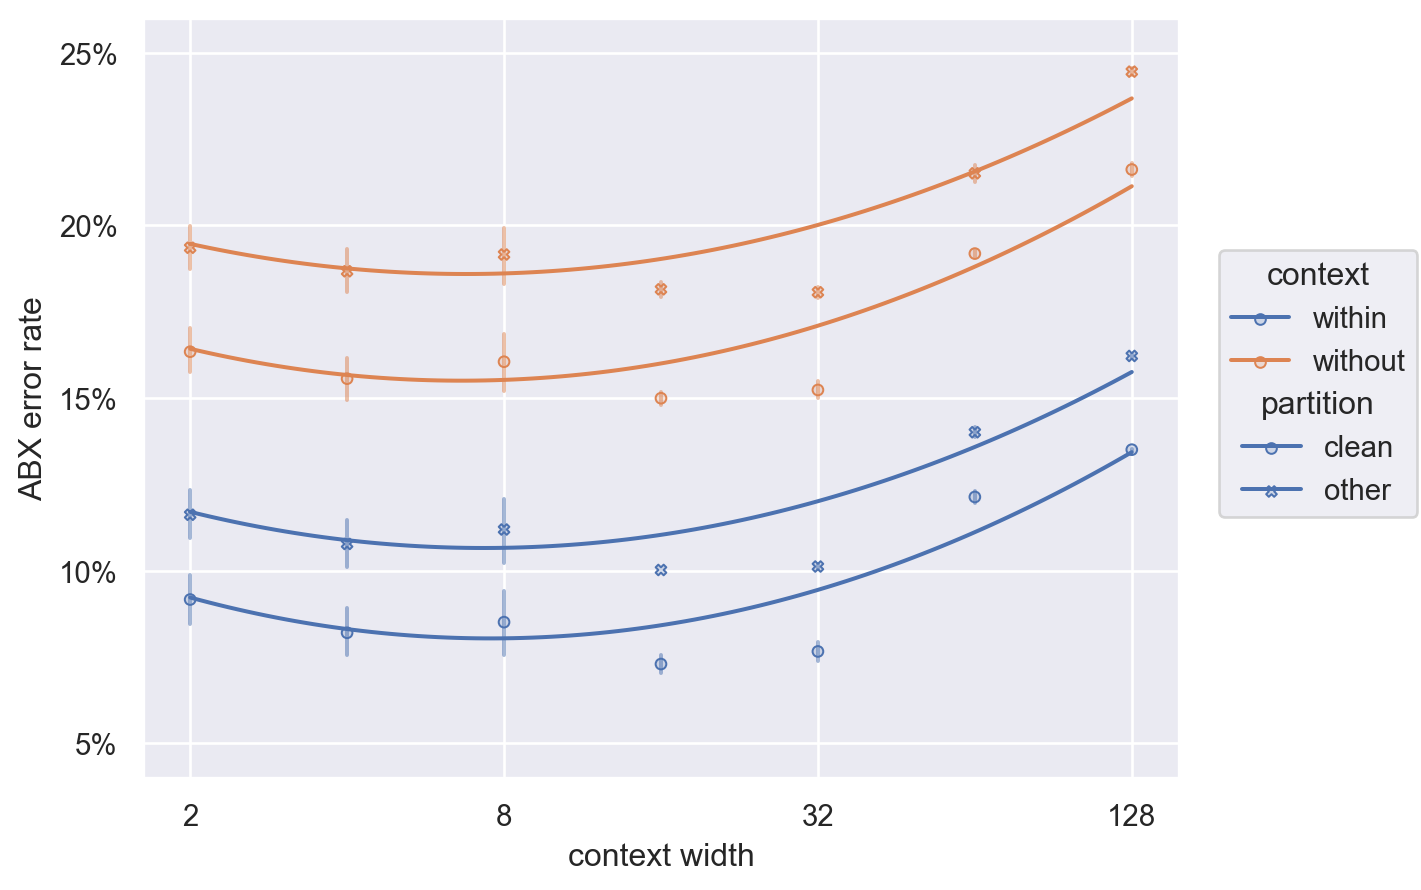

In [ ]:
# plot libriABX scores across subsets and context windows w/ phoneme granularity

# fig, ax = plt.subplots()
# # cpc.small results
# df = filter_data_equal(dfz, {
#     'name': 'cpc.small/version_2',
#     "zrc.pca_style": "full",
#     "zrc.speaker_mode": "within",
#     "zrc.granularity": "phoneme",
# }).copy()
# df['zrc.subset'] = df['zrc.subset'].map(
#     {
#         'test-clean': 'clean',
#         'test-other': 'other',
#         'dev-clean': 'clean',
#         'dev-other': 'other'}
# )
# df['zrc.context_mode'] = df['zrc.context_mode'].map({'within': 'within', 'any': 'without'})
# df = (
#     df[['zrc.context_mode', 'zrc.subset', 'zrc.score']]
#     .groupby(['zrc.context_mode', 'zrc.subset']).mean()
# )
# ax.axhline(y=df.loc[('within', 'clean'), 'zrc.score'], color=sns.color_palette()[0], linestyle='--', alpha=0.75)
# ax.axhline(y=df.loc[('without', 'clean'), 'zrc.score'], color=sns.color_palette()[1], linestyle='--', alpha=0.75)

df = filter_data_equal(dfz, {
    "zrc.pca_style": "full",
    "conv.norm_type": "none",
    "context_type": "csa",
    "training.cpc_loss.prediction_steps": 12,
    "training.cpc_loss.gutted_steps": 0,
    "training.cpc_loss.negative_samples": 128,
    "training.loss_type": "cpc",
    "zrc.granularity": "phoneme",
    'training.cpc_loss.averaging_penalty': 0,
    "csa.dim_feedforward": 1024,
    "csa.num_layers": 1,
    "zrc.speaker_mode": "within",
})
df = filter_data_in(
    df, {"csa.max_width": range(2, 65)}
)
check_data(
    df,
    "csa.max_width", "zrc.subset", "zrc.score",
    "zrc.context_mode", "training.cpc_loss.offset"
)
df['zrc.subset'] = df['zrc.subset'].map(
    {
        'test-clean': 'clean',
        'test-other': 'other',
        'dev-clean': 'clean',
        'dev-other': 'other'}
)
df['zrc.context_mode'] = df['zrc.context_mode'].map({'within': 'within', 'any': 'without'})
df['zrc.sbyc'] = df.agg("{0[zrc.subset]}-{0[zrc.context_mode]}".format, axis=1)

plot = (
    so.Plot(df, x="csa.max_width", y="zrc.score", color="zrc.context_mode", marker="zrc.subset")
    .limit(y=(0.04, 0.26))
    .add(so.Dots(), so.Agg())
    .add(so.Range(alpha=0.5), so.Est(), group='zrc.sbyc')
    .add(so.Line(marker=None), so.PolyFit())
    .scale(
        x=(
            so.Continuous(trans="log")
            .tick(at=[2, 8, 32, 128])
            .label(like='d', base=2)
        ),
        y=(
            so.Continuous()
            .tick(at=[0.05, 0.1, 0.15, 0.2, 0.25])
            .label(like='.0%')
        ),
    )
    .label(x="context width", y="ABX error rate", color="context", marker="partition")
    .plot()
)

# legend = fig.legends[0]
# legend.set_bbox_to_anchor((0.7, 0.2))

plot.save('../resources/libriabx_context_subset_phoneme.pdf')

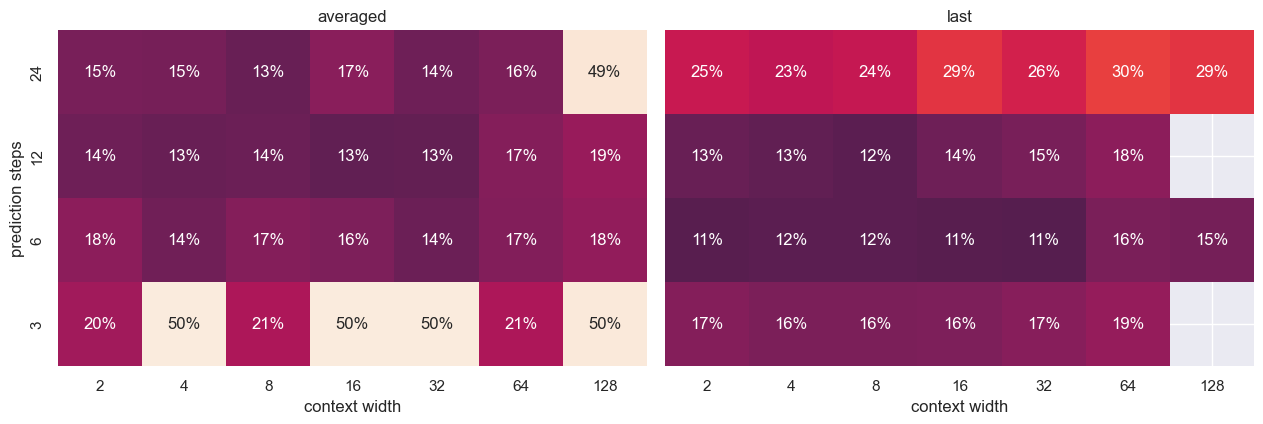

In [5]:
# plot libriABX score of context width vs prediction steps (averaged)
# - this one will show up on the left of our figure, so it doesn't have the cbar
#   but does have the y axis label
fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.8), sharey=True)

df = filter_data_equal(dfz, {
    "zrc.pca_style": "full",
    "conv.norm_type": "none",
    "context_type": "csa",
    "training.loss_type": "cpc",
    "training.cpc_loss.gutted_steps": 0,
    'training.cpc_loss.averaging_penalty': 0,
    "zrc.granularity": "phoneme",
    "csa.dim_feedforward": 1024,
    "csa.num_layers": 1,
    "zrc.speaker_mode": "within",
})
df = filter_data_in(
    df, {
        "csa.max_width": range(2, 129),
        "training.cpc_loss.prediction_steps": range(2, 25)
    }
)
check_data(
    df,
    "csa.max_width", "zrc.subset", "zrc.score",
    "zrc.context_mode", "training.cpc_loss.offset",
    "training.cpc_loss.prediction_steps",
    "training.cpc_loss.negative_samples",
)
df = df.pivot_table(
    columns="csa.max_width",
    index="training.cpc_loss.prediction_steps",
    values="zrc.score"
).sort_values(by='training.cpc_loss.prediction_steps', ascending=False)
plot = sns.heatmap(df, annot=True, fmt=".0%", vmin=0.0, vmax=0.5, cbar=False, square=True, ax=axs[0])
plot.set(xlabel='context width', ylabel='prediction steps', title='averaged')
plot.set_xticklabels([f'{int(x):d}' for x in sorted(df.columns)])

df = filter_data_equal(dfz, {
    "zrc.pca_style": "full",
    "conv.norm_type": "none",
    "context_type": "csa",
    "training.loss_type": "cpc",
    'training.cpc_loss.averaging_penalty': 0,
    "training.cpc_loss.negative_samples": 128,
    "zrc.granularity": "phoneme",
    "csa.dim_feedforward": 1024,
    "csa.num_layers": 1,
    "zrc.speaker_mode": "within",
})
df = filter_data_in(
    df, {"csa.max_width": range(2, 129)}
)
idx = df['training.cpc_loss.prediction_steps'] == 1
for n in range(2, 25):
    idx |= (df['training.cpc_loss.prediction_steps'] == n) & (df['training.cpc_loss.gutted_steps'] == (n - 1))
df = df.loc[idx]
check_data(
    df,
    "csa.max_width", "zrc.subset", "zrc.score",
    "zrc.context_mode", "training.cpc_loss.offset",
    "training.cpc_loss.prediction_steps",
    "training.cpc_loss.gutted_steps",
)
df = df.pivot_table(
    columns="csa.max_width",
    index="training.cpc_loss.prediction_steps",
    values="zrc.score"
).sort_values(by='training.cpc_loss.prediction_steps', ascending=False)
plot = sns.heatmap(df, annot=True, fmt=".0%", vmin=0.0, vmax=0.5, square=True, cbar=False, ax=axs[1])
plot.set(xlabel='context width', ylabel=None, title='last')
plot.set_xticklabels([f'{int(x):d}' for x in sorted(df.columns)])
plot.set_yticklabels([f'{int(x):d}' for x in sorted(df.index, reverse=True)])

fig.tight_layout()
fig.savefig("../resources/libriabx_prediction_steps_vs_width.pdf")

## Tensorboard analysis

In [6]:
# load data
dft = collate_data("tb")
dft.head(10)

,tb.step,tb.epoch,tb.val_loss,name,feat_type,train_part,input_size,latent_type,context_type,conv.output_size,...,training.cpc_loss.averaging_penalty,training.best_rq_loss.mask_prob,training.best_rq_loss.mask_width,training.best_rq_loss.codebook_size,training.best_rq_loss.codebook_dim,training.best_rq_loss.offset,training.best_rq_loss.speaker_regex,training.best_rq_loss.prediction_type,training.shuffle,training.max_epochs
0,1901,0,0.458719,bestrq.small/version_1,fbank-80,100,80,ff,recur,NaN,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
1,3803,1,0.340937,bestrq.small/version_1,fbank-80,100,80,ff,recur,NaN,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
2,5705,2,0.271982,bestrq.small/version_1,fbank-80,100,80,ff,recur,NaN,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
3,7607,3,0.228843,bestrq.small/version_1,fbank-80,100,80,ff,recur,NaN,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
4,9509,4,0.202791,bestrq.small/version_1,fbank-80,100,80,ff,recur,NaN,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
5,11411,5,0.189972,bestrq.small/version_1,fbank-80,100,80,ff,recur,NaN,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
6,13313,6,0.170144,bestrq.small/version_1,fbank-80,100,80,ff,recur,NaN,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
7,15215,7,0.153720,bestrq.small/version_1,fbank-80,100,80,ff,recur,NaN,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
8,17117,8,0.145142,bestrq.small/version_1,fbank-80,100,80,ff,recur,NaN,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200
9,19019,9,0.149311,bestrq.small/version_1,fbank-80,100,80,ff,recur,NaN,...,NaN,0.01,40.0,8192.0,16.0,0.0,^lbi-([^-]+)-.*$,sa,False,200


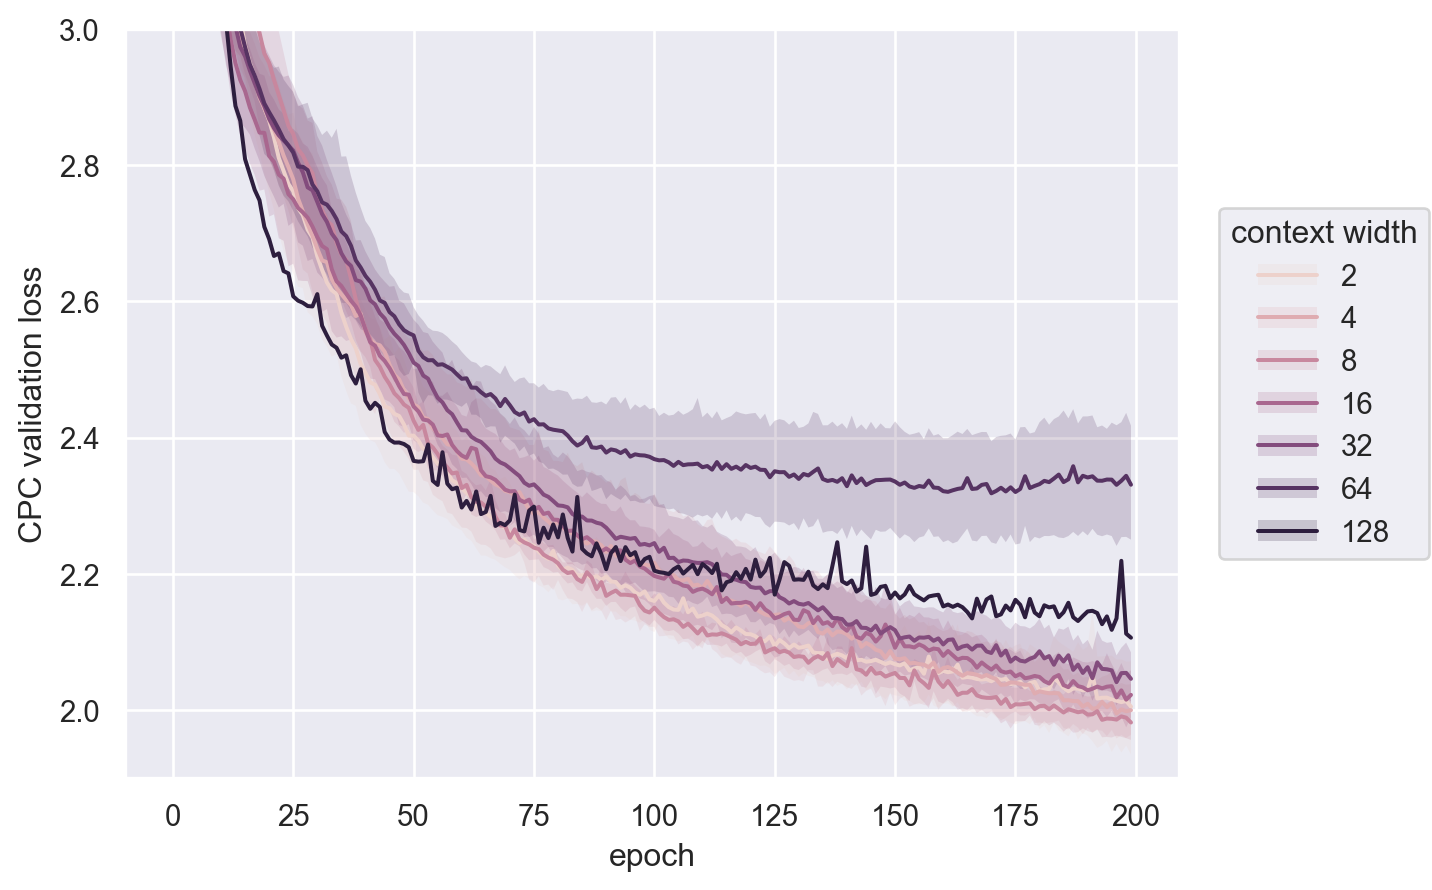

In [9]:
df = filter_data_equal(dft, {
    "conv.norm_type": "none",
    "context_type": "csa",
    "training.loss_type": "cpc",
    "training.cpc_loss.gutted_steps": 0,
    'training.cpc_loss.averaging_penalty': 0,
    "training.cpc_loss.prediction_steps": 12,
    "csa.dim_feedforward": 1024,
    "csa.num_layers": 1,
})
df = filter_data_in(
    df, {"csa.max_width": (2, 4, 8, 16, 32, 64, 128)}
).copy()
check_data(
    df, "tb.epoch", "tb.val_loss", "tb.step", "csa.max_width", "csa.num_layers",
    "training.cpc_loss.offset"
)
df['csa.max_width'] = df['csa.max_width']#.astype('int')#.astype('category')
plt = (
    so.Plot(df, x="tb.epoch", y="tb.val_loss", color="csa.max_width")
    .limit(y=(1.9, 3.0))
    .add(so.Line(), so.Agg())
    .add(so.Band(), so.Est(), group="csa.max_width")
    .label(x="epoch", y="CPC validation loss", color="context width")
    .scale(
        color=so.Continuous(trans="log")
            .tick(at=(2, 4, 8, 16, 32, 64, 128))
            .label(like=".0f"))
)
plt.save('../resources/train_loss_vs_width.pdf')